In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import pymc3 as pm 
from scipy import stats
%matplotlib inline

#Reproducible results
np.random.seed(123)

#Load the data
x, data, uncertainties=np.genfromtxt('vd_Data.txt', unpack=True)
index=np.arange(1, len(x)+1)

#pymc3 model
with pm.Model() as model:
    sig_hyperprior=pm.Uniform('sig', 0.0, 50.0)
    vel_hyperprior=pm.Normal('vel', 0.0, 50.0)

    vel_tracers=pm.Normal('vel-tracers', mu=vel_hyperprior, sd=uncertainties, shape=len(data))


    measurements=pm.Normal('measurements', mu=vel_tracers, sd=sig_hyperprior, observed=data)
    trace=pm.sample(2000, tune=10000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [vel-tracers, vel, sig_interval__]
100%|██████████| 12000/12000 [00:18<00:00, 663.13it/s]
The acceptance probability does not match the target. It is 0.6856831394682252, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


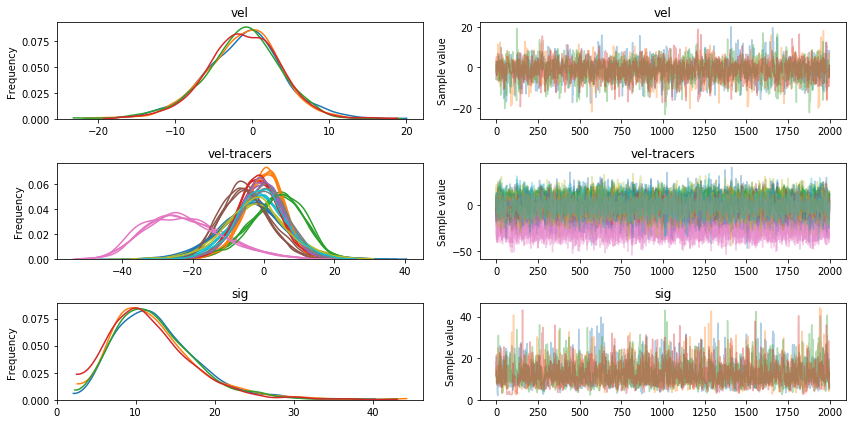

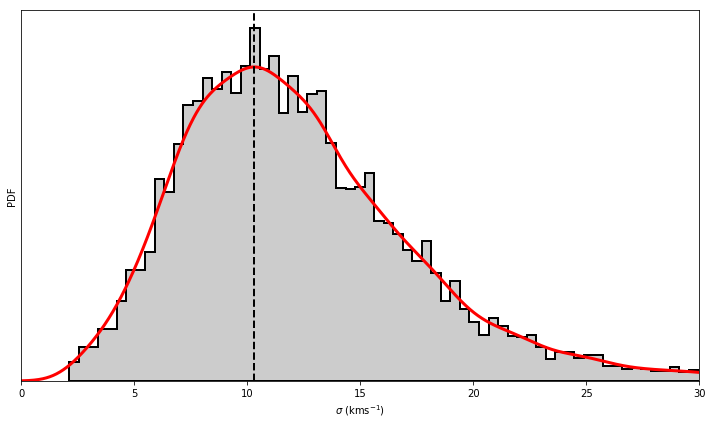

In [3]:
#Plot these traces
pm.traceplot(trace)
plt.savefig('traceplot.pdf')
#Make a KDE approximation to the sigma posterior
xx=np.linspace(0.0, 30.0, 1000)
kde_approximation=stats.gaussian_kde(trace['sig'])


#Plot things
fig, ax=plt.subplots(figsize=(10, 6))
ax.plot(xx, kde_approximation(xx), c='r', linewidth=3.0)
ax.hist(trace['sig'], 100, facecolor='0.8', edgecolor='k',  histtype='stepfilled', normed=True, linewidth=2.0)

ax.axvline(xx[np.argmax(kde_approximation(xx))], c='k', linestyle='dashed', linewidth=2.0)


ax.set_xlim([0.0, 30.0])
ax.set_ylabel(r'PDF')
ax.set_yticks([])
#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$\sigma$ (kms$^{-1}$)')

fig.tight_layout()
fig.savefig('pdf.pdf')




In [4]:

#Outlier detection
#This follows the analysis from Hogg, Bovy and Lang (2010): https://arxiv.org/pdf/1008.4686.pdf
#And is edited slightly from the pymc3 tutorial 
#here: https://docs.pymc.io/notebooks/GLM-robust-with-outlier-detection.html

import theano as thno
import theano.tensor as T


def logp_signoise(data, isoutlier, velin, sigin, velout, sigout):
    '''
    Define custom loglikelihood for inliers vs outliers.
    NOTE: in this particular case we don't need to use theano's @as_op
    decorator because (as stated by Twiecki in conversation) that's only
    required if the likelihood cannot be expressed as a theano expression.
    We also now get the gradient computation for free.
    '''

    # likelihood for inliers

    pdfs_in = T.exp(-(data - velin + 1e-4)**2 / (2 * sigin**2))
    pdfs_in /= T.sqrt(2 * np.pi * sigin**2)
    logL_in = T.sum(T.log(pdfs_in) * (1 - isoutlier))

    # likelihood for outliers
    pdfs_out = T.exp(-(data - velout + 1e-4)**2 / (2 * (sigin**2 + sigout**2)))
    pdfs_out /= T.sqrt(2 * np.pi * (sigin**2 + sigout**2))
    logL_out = T.sum(T.log(pdfs_out) * isoutlier)

    return logL_in + logL_out



with pm.Model() as mdl_signoise:

    sig_hyperprior=pm.Uniform('sig', 0.0, 50.0)
    vel_hyperprior=pm.Normal('vel', 0.0, 50.0)

    vel_tracers=pm.Normal('vel-tracers', mu=vel_hyperprior, sd=uncertainties, shape=len(data))

    ## Define weakly informative priors for the mean and variance of outliers
    vel_out = pm.Normal('vel-out', mu=0, sd=100, testval=pm.floatX(1.))
    sig_out = pm.HalfNormal('sig-out', sd=100, testval=pm.floatX(1.))

    ## Define Bernoulli inlier / outlier flags according to a hyperprior
    ## fraction of outliers, itself constrained to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac-outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is-outlier', p=frac_outliers, shape=len(data))

    ## Extract observed y and sigma_y from dataset, encode as theano objects
    data_thno = thno.shared(np.asarray(data, dtype=thno.config.floatX), name='data')
    uncert_thno = thno.shared(np.asarray(uncertainties, dtype=thno.config.floatX),
                             name='uncertainties')

    ## Use custom likelihood using DensityDist
    likelihood = pm.DensityDist('likelihood', logp_signoise,
                        observed={'data': data_thno, 'isoutlier': is_outlier,
                                  'velin': vel_tracers, 'sigin': sig_hyperprior,
                                  'velout': vel_out, 'sigout': sig_out})



with mdl_signoise:
    ## two-step sampling to create Bernoulli inlier/outlier flags
    step1 = pm.Metropolis([frac_outliers, vel_out, sig_out])
    step2 = pm.step_methods.BinaryGibbsMetropolis([is_outlier])

    ## take samples
    #I got an error here when njobs>1. Not too sure why!
    traces_signoise = pm.sample(20000, step=[step1, step2], tune=10000, progressbar=True, njobs=1)


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [sig-out_log__]
>>Metropolis: [vel-out]
>>Metropolis: [frac-outliers_interval__]
>BinaryGibbsMetropolis: [is-outlier]
>NUTS: [vel-tracers, vel, sig_interval__]
100%|█████████▉| 29984/30000 [01:25<00:00, 350.12it/s]/home/vaughan-l/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
100%|██████████| 30000/30000 [01:24<00:00, 354.95it/s]
Tuning was enabled throughout the whole trace.
Tuning was enabled throughout the whole trace.
The number of effective samples is smaller than 10% for some parameters.


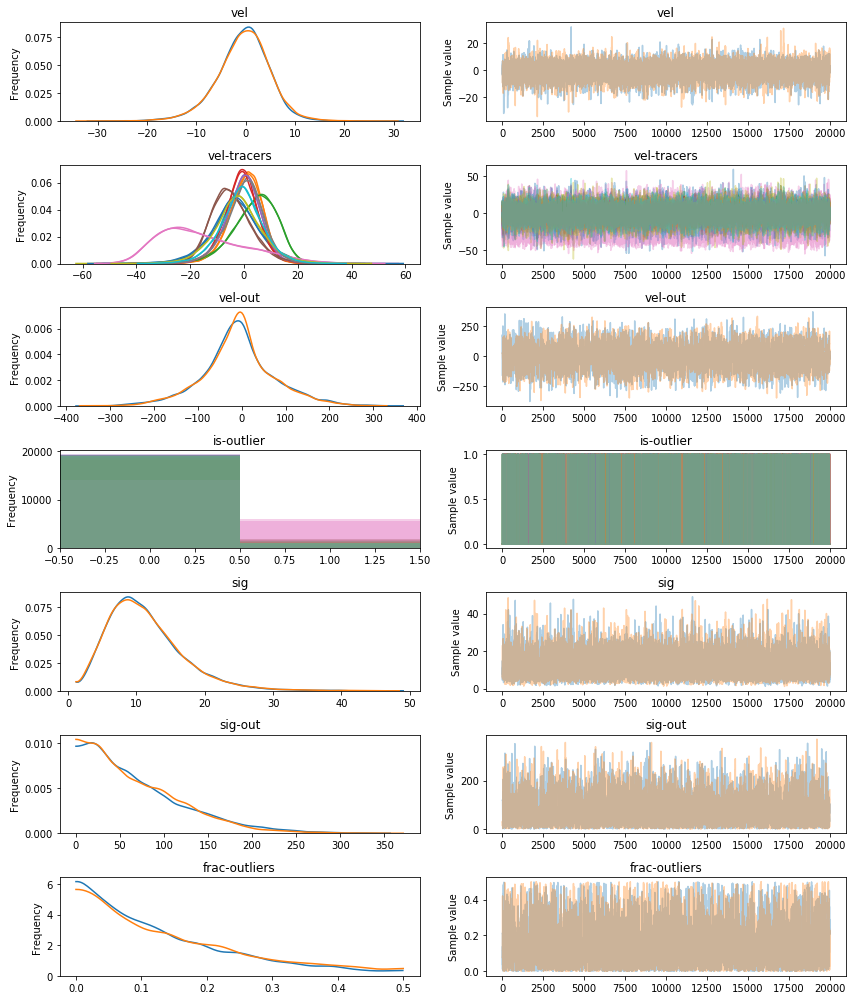

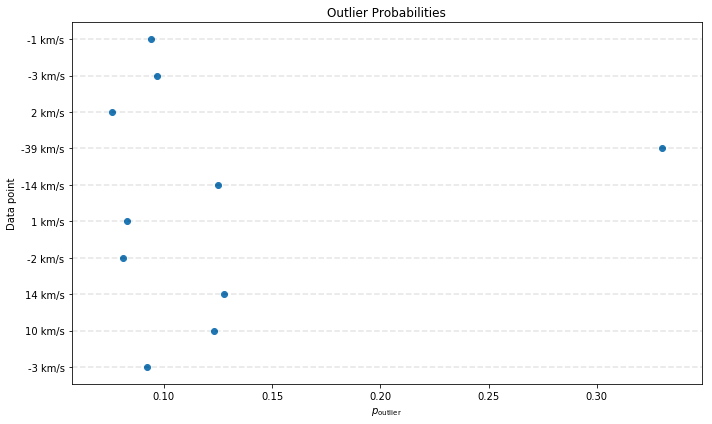

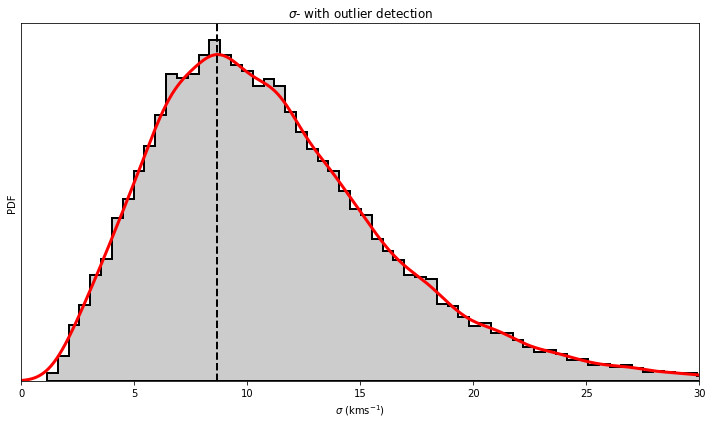

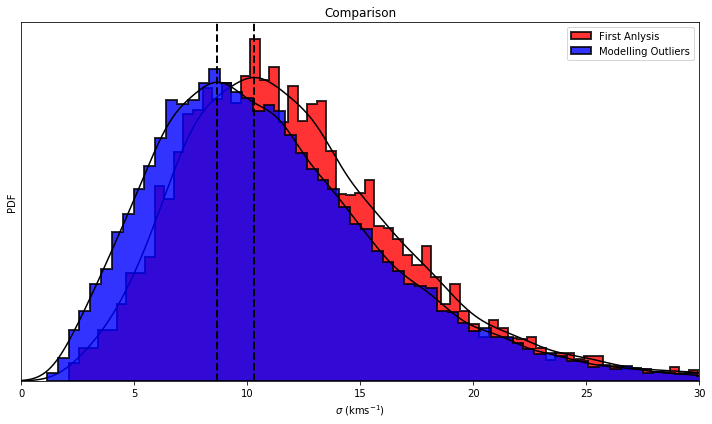

In [5]:
#Plot things
pm.traceplot(traces_signoise)
plt.savefig('outlier_traceplot.pdf')


fig, ax=plt.subplots(figsize=(10, 6))
mean_outlier_prob=np.mean(traces_signoise['is-outlier'][-1000:, :], axis=0)
ax.scatter(mean_outlier_prob, index)
ax.set_yticks(index)
ax.set_yticklabels(["{} km/s".format(int(d)) for d in data])
for i in index:
    ax.axhline(i, c='k', alpha=0.1, linestyle='dashed')

ax.set_title('Outlier Probabilities')
ax.set_xlabel(r'$p_{\mathrm{outlier}}$')
ax.set_ylabel('Data point')
fig.tight_layout()
fig.savefig('outlier_probabilities.pdf')



#KDE approximation to the new posterior
xx=np.linspace(0.0, 30.0, 1000)
kde_approximation2=stats.gaussian_kde(traces_signoise['sig'])


fig, ax=plt.subplots(figsize=(10, 6))
ax.plot(xx, kde_approximation2(xx), c='r', linewidth=3.0)
ax.hist(traces_signoise['sig'], 100, facecolor='0.8', edgecolor='k',  histtype='stepfilled', normed=True, linewidth=2.0)
ax.axvline(xx[np.argmax(kde_approximation2(xx))], c='k', linestyle='dashed', linewidth=2.0)

ax.set_title(r'$\sigma$- with outlier detection')
ax.set_xlim([0.0, 30.0])
ax.set_ylabel(r'PDF')
ax.set_yticks([])
#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$\sigma$ (kms$^{-1}$)')

fig.tight_layout()
fig.savefig('pdf_outliers.jpg')

#Compare the two 
fig, ax=plt.subplots(figsize=(10, 6))
ax.set_title('Comparison')

ax.plot(xx, kde_approximation(xx), c='k', zorder=2)
ax.hist(trace['sig'], 100, facecolor='r', edgecolor='k',  histtype='stepfilled', normed=True, 
    linewidth=2.0, alpha=0.8, label='First Anlysis', zorder=2)
ax.plot(xx, kde_approximation2(xx), c='k', zorder=3)

ax.hist(traces_signoise['sig'], 100, facecolor='b', edgecolor='k',  histtype='stepfilled', 
    normed=True, linewidth=2.0, alpha=0.8, label='Modelling Outliers', zorder=3)

ax.axvline(xx[np.argmax(kde_approximation2(xx))], c='k', linestyle='dashed', linewidth=2.0, zorder=10)
ax.axvline(xx[np.argmax(kde_approximation(xx))], c='k', linestyle='dashed', linewidth=2.0, zorder=10)

ax.set_xlim([0.0, 30.0])
ax.set_ylabel(r'PDF')
ax.set_yticks([])
#ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel(r'$\sigma$ (kms$^{-1}$)')
ax.legend()
fig.tight_layout()
fig.savefig('pdf_comparison.pdf')
plt.show()
